4500
18500


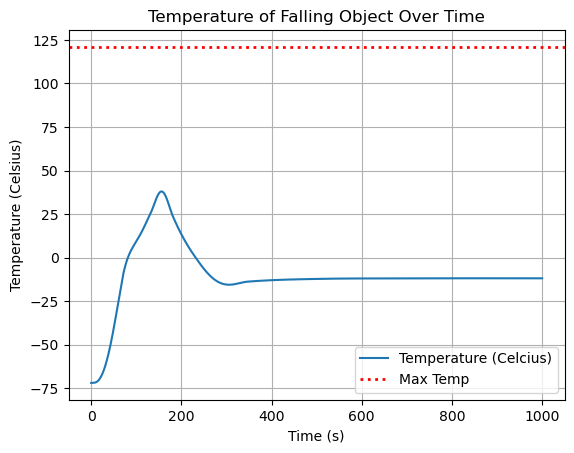

C:\Users\david\AppData\Local\Temp\ipykernel_5224\3699602200.py:133: RuntimeWarning: overflow encountered in cosh
  recorred_distance_after = (tau*V_t)*np.log(np.cosh((t-t_parachute)/tau))


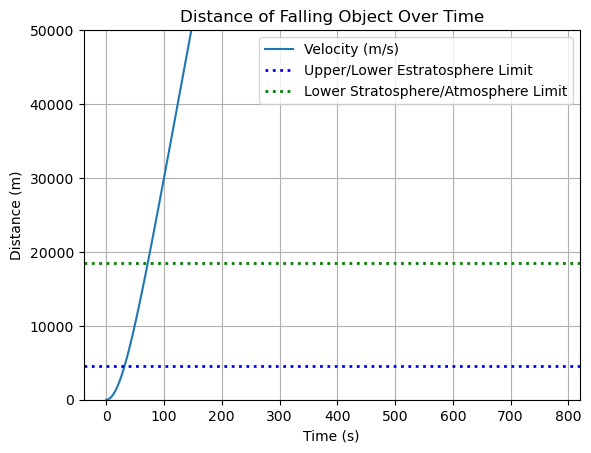

Time at wich the object goes through the Upper/Lower Stratosphere limit is  [31.528212]
Time at wich the object goes through the Stratosphere/Troposphere limit is  [71.95572756]
Tiempo en el que la velocidad es máxima: 71.95574578839037
Velocidad máxima: 55.05208177016267


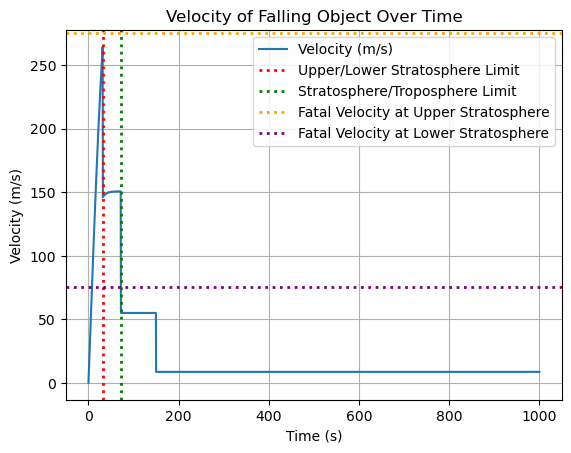

Fatal Velocity at Upper Stratosphere 275.13411363879413
Fatal Velocity at Lower Stratosphere 75.34858018957867
Fatal Velocity at Troposphere 27.513411363879417


In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


# Constants
c =  1000     # Specific Heat Capacity J/(kg*K)
h = 50        # Heat Transfer Coefficient W/(m^2*K)
m = 190      # Mass kg
g = 9.81   # Gravitational m/s2
C = 2.05      # Air Resistance Coefficient
rho = 1.23  # Air Density kg/m3 
A = 1     # Cross Sectional Area m2
F_max = 16758 # Max Force that a can withstand N 


# Initial Conditions
T_initial = 201  # Initial Object Temperature in K , - 72 Celsius Degrees


# ------------------------------------------------------------------------------------------------------------------------
#                                               SIMULATION PARAMETERS


t_parachute = 150  # El tiempo en el que el paracaídas se abre, en segundos
A_initial = 1      # El valor de la sección transversal antes de abrir el paracaídas, en m^2
A_new = 40         # El nuevo valor de la sección transversal, en m^2
simulation_time = 1000 # tiempo de simulacion


# ------------------------------------------------------------------------------------------------------------------------

jump_heigth = 29500

U_stratosphre_limit = jump_heigth - 25000
L_stratosphre_limit = jump_heigth - 11000
Trophopere_limit = jump_heigth 

print(U_stratosphre_limit)
print(L_stratosphre_limit)

def T_air(x):
    if U_stratosphre_limit > x:
        return 254  # upper stratosphere
    elif U_stratosphre_limit <= x <= L_stratosphre_limit:
        return 217  #  lower stratosphere
    elif L_stratosphre_limit < x : 
        return 253  #  troposphere
    
def rho(x):
    if U_stratosphre_limit > x:
        return 0.01  # upper stratosphere
    elif U_stratosphre_limit <= x <= L_stratosphre_limit:
        return 0.08  # lower stratosphere
    elif L_stratosphre_limit < x : 
        return 0.6  # troposphere
    

def x(t, V_t, tau):
    return (tau*V_t)*np.log(np.cosh(t/tau)) 

# Funtion that represents the diferential equation of tempeture of the object over time
def dTdt(t, T):
    A = A_initial if t < t_parachute else A_new
    
    rho_value = rho(0)
    V_t = np.sqrt((2*m*g) / (C*rho_value*A))
    tau = np.sqrt((2*m) / (C*rho_value*A*g))
    
    x_value = x(t, V_t, tau)
    
    rho_value = rho(x_value)
    V_t = np.sqrt((2*m*g) / (C*rho_value*A))
    tau = np.sqrt((2*m) / (C*rho_value*A*g))
    
    velocity = V_t * np.tanh(g*t/V_t)
    F_drag = 0.5 * rho_value * (velocity**2) * C * A
    power_drag = F_drag * velocity
    power_conv = h * A * (T - T_air(x_value))
    return [(power_drag - power_conv) / (m * c)]



# Simulation Time 
t_span = (0, simulation_time)         # Time Range
t_eval = np.linspace(*t_span, 2000)  # Time Evaluation



# Solve Diferential Equation
sol = solve_ivp(dTdt, t_span, [T_initial], t_eval=t_eval, method='RK45')

# PLot SOlution
plt.plot(sol.t, sol.y[0] - 273, label='Temperature (Celcius)')
plt.title('Temperature of Falling Object Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (Celsius)')
plt.grid(True)
valor_deseado = 121  
plt.axhline(y=valor_deseado, color='r', linestyle=':', linewidth=2, label='Max Temp')
plt.legend()
plt.show()

# Convert Temperature to Celsius for ploting
temperatures_celsius = sol.y[0] - 273


# Find Time index at max temp
desired_temp_k = 121 + 273  # Covert to kelvin
time_at_desired_temp = None
for i, temp in enumerate(temperatures_celsius):
    if temp >= 121 :  # Check if Temperature is higher than 121 celsius
        time_at_desired_temp = sol.t[i]
        break


# plot distance for reference

def x_opening_parachute(t):
    A_i = A_initial
    rho_value = rho(0)  # Asumiendo un valor inicial de x = 0
    V_t_i = np.sqrt((2*m*g) / (C*rho_value*A_i))  
    tau_i = np.sqrt((2*m) / (C*rho_value*A_i*g))  
    
    if t < t_parachute:
        return (tau_i*V_t_i)*np.log(np.cosh(t/tau_i))
    else:
        recorred_distance = (tau_i*V_t_i)*np.log(np.cosh(t_parachute/tau_i))
        A = A_new
        rho_value = rho(recorred_distance)  # Usando la distancia recorrida para obtener rho
        V_t = np.sqrt((2*m*g) / (C*rho_value*A))
        tau = np.sqrt((2*m) / (C*rho_value*A*g))
        recorred_distance_after = (tau*V_t)*np.log(np.cosh((t-t_parachute)/tau))
        return recorred_distance + recorred_distance_after


plt.figure()
plt.plot(sol.t, [x_opening_parachute(t) for t in sol.t], label='Velocity (m/s)')
plt.title('Distance of Falling Object Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.ylim(0,50000)
if time_at_desired_temp is not None:
    valor_deseado = x_opening_parachute(time_at_desired_temp)  
    plt.axhline(y=valor_deseado, color='r', linestyle=':', linewidth=2, label='Max Temp')    

valor_deseado = U_stratosphre_limit 
plt.axhline(y=valor_deseado, color='b', linestyle=':', linewidth=2, label='Upper/Lower Estratosphere Limit')

valor_deseado = L_stratosphre_limit 
plt.axhline(y=valor_deseado, color='green', linestyle=':', linewidth=2, label='Lower Stratosphere/Atmosphere Limit')

plt.legend()
plt.grid(True)
plt.show()


# Velocity as funtion of time
def velocity(t):
    x = x_opening_parachute(t)  
    A = A_initial if t < t_parachute else A_new
    rho_value = rho(x)  
    V_t = np.sqrt((2*m*g) / (C*rho_value*A))
    return V_t * np.tanh(g*t/V_t)


velocities = [velocity(t) for t in sol.t]


from scipy.optimize import fsolve


# Estimate time at wich object goes through each layer limit
x_desired_1 = U_stratosphre_limit  
def equation_to_solve_1(t):
    return x_opening_parachute(t) - x_desired_1
# Adivinanza inicial para el tiempo
initial_guess = 0
# Usar fsolve para encontrar el tiempo en que x = x_desired
time_when_x_desired_1 = fsolve(equation_to_solve_1, initial_guess)
print('Time at wich the object goes through the Upper/Lower Stratosphere limit is ',time_when_x_desired_1)

# Estimate time at wich object crosses each layer
x_desired_2 = L_stratosphre_limit 
def equation_to_solve_2(t):
    return x_opening_parachute(t) - x_desired_2
# Adivinanza inicial para el tiempo, por ejemplo, t = 0
initial_guess = 0
# Usar fsolve para encontrar el tiempo en que x = x_desired
time_when_x_desired_2 = fsolve(equation_to_solve_2, initial_guess)
print('Time at wich the object goes through the Stratosphere/Troposphere limit is ',time_when_x_desired_2)


from scipy.optimize import fminbound

# Definir el intervalo de tiempo en el que estás interesado, por ejemplo, de 0 a 100 segundos
t_min = 0
t_max = 200
# Usar fminbound para encontrar el tiempo en el que la velocidad es máxima
t_at_max_velocity = fminbound(velocity, t_min, t_max)
# Calcular la velocidad máxima
max_velocity = velocity(t_at_max_velocity)

print(f'Tiempo en el que la velocidad es máxima: {t_at_max_velocity}')
print(f'Velocidad máxima: {max_velocity}')

# calculate max terminal velocity that a person can withstand as a function of cross section A.
def V_terminal_max(A,rho):
    return np.sqrt((2*(F_max+m*g)) / (C*rho*A))

v_fatal_upper_strat = V_terminal_max(A=A_new,rho= 0.006 )
v_fatal_lower_strat = V_terminal_max(A=A_new,rho= 0.08 )
v_fatal_trop = V_terminal_max(A=A_new,rho= 0.6 )


# Plot Velocity vs time
plt.figure()
plt.plot(sol.t, velocities, label='Velocity (m/s)')
plt.title('Velocity of Falling Object Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
valor_deseado = time_when_x_desired_1  
plt.axvline(x=valor_deseado, color='r', linestyle=':', linewidth=2, label='Upper/Lower Stratosphere Limit')
valor_deseado = time_when_x_desired_2 
plt.axvline(x=valor_deseado, color='green', linestyle=':', linewidth=2, label='Stratosphere/Troposphere Limit')
valor_deseado = v_fatal_upper_strat 
plt.axhline(y=valor_deseado, color='orange', linestyle=':', linewidth=2, label='Fatal Velocity at Upper Stratosphere')
valor_deseado = v_fatal_lower_strat 
plt.axhline(y=valor_deseado, color='purple', linestyle=':', linewidth=2, label='Fatal Velocity at Lower Stratosphere')


plt.legend()
plt.grid(True)
plt.show()


print("Fatal Velocity at Upper Stratosphere" ,v_fatal_upper_strat )

print("Fatal Velocity at Lower Stratosphere" ,v_fatal_lower_strat )

print("Fatal Velocity at Troposphere" ,v_fatal_trop )



 

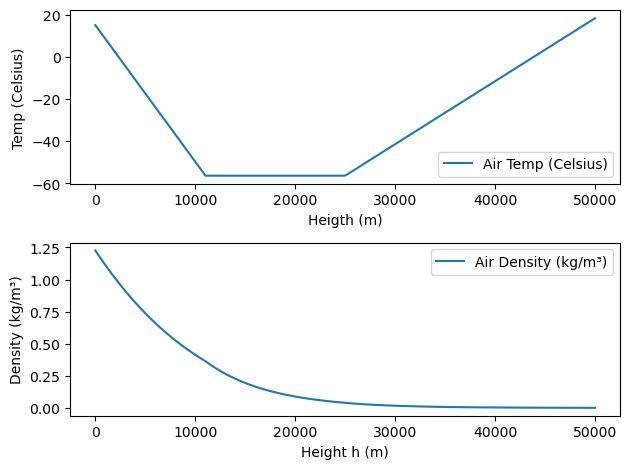

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# Plots of temp and rho as function of heigth for the estratosphre and troposphere models


def T_air(h):

    if h > 25000:
        return -131.21 + 0.00299 * h 
    
    elif 11000 <= h <= 25000:
        return -56.46 
    
    elif 0 <= h <= 11000:
        return 15.04 - 0.00649 * h 
    
    
def rho_air(h):
    T = T_air(h) + 273.15  
    h  
    if h > 25000:
        return (1 / (0.2869 * T)) * (2.488 * (T / 216.6)**-11.388)
    elif 11000 <= h <= 25000:
        return (1 / (0.2869 * T)) * 22.65 * np.exp(1.73 - 0.000157 * h)
    else:
        return (1 / (0.2869 * T)) * 101.29 * (T / 288.08)**5.256



x_values = np.linspace(0, 50000, 400)


T_air_values = [T_air(x) for x in x_values]
rho_air_values = [rho_air(x) for x in x_values]

plt.figure()

plt.subplot(2, 1, 1)  
plt.plot(x_values, T_air_values, label='Air Temp (Celsius)')
plt.xlabel('Heigth (m)')
plt.ylabel('Temp (Celsius)')
plt.legend()


plt.subplot(2, 1, 2) 
plt.plot(x_values, rho_air_values, label='Air Density (kg/m³)')
plt.xlabel('Height h (m)')
plt.ylabel('Density (kg/m³)')
plt.legend()


plt.tight_layout()  
plt.show()


In [4]:
# estimate mean values for T and rho for the 3 layers of the atmoshpre considered

# here layer 1 = Upper Estratosphere
# here layer 2 = Lower Estratosphere
# here layer 2 = Lower Troposphere


region_bounds = [(0, 11000), (11000, 25000), (25000, 50000)]


T_air_avg = []
rho_air_avg = []


for bounds in region_bounds:
    h_values = np.linspace(*bounds, 10000)  
    T_air_values = np.array([T_air(h) for h in h_values])
    rho_air_values = np.array([rho_air(h) for h in h_values])
    T_air_avg.append(np.mean(T_air_values))
    rho_air_avg.append(np.mean(rho_air_values))


for i, bounds in enumerate(region_bounds):
    print(f"Layer {i+1} ({bounds[0]} <= h < {bounds[1]}):")
    print(f"    T_air mean: {T_air_avg[i]:.2f} Celsius")
    print(f"    rho_air mean: {rho_air_avg[i]:.4f} kg/m³")


Layer 1 (0 <= h < 11000):
    T_air mean: -20.66 Celsius
    rho_air mean: 0.7316 kg/m³
Layer 2 (11000 <= h < 25000):
    T_air mean: -56.46 Celsius
    rho_air mean: 0.1478 kg/m³
Layer 3 (25000 <= h < 50000):
    T_air mean: -19.09 Celsius
    rho_air mean: 0.0098 kg/m³
